## Complex Network Analysis: Premier League - Basic Functions

This notebook implements basic functions to load Premier League data, create a complex network for a specific season, and visualize this network.

In [57]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import warnings
import community as co
import seaborn as sns
from typing import List
from collections import defaultdict

# Ignore some common warnings for a cleaner display
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')
warnings.filterwarnings('ignore', category=FutureWarning) # For newer pandas and networkx versions

### 1. Data Loading

Function to load the dataset.

In [58]:
def load_data(file_path):
    """
    Loads the dataset from a CSV file.
    
    Args:
        file_path (str): The path to the CSV file.
        
    Returns:
        pandas.DataFrame: The loaded DataFrame, or None if the file is not found.
    """
    try:
        df = pd.read_csv(file_path)
        print(f"Data loaded successfully from {file_path}")
        print(f"Dataset shape: {df.shape}")
        # Convert MatchDate to datetime if not already
        if 'MatchDate' in df.columns:
             df['MatchDate'] = pd.to_datetime(df['MatchDate'], errors='coerce')
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None

### 2. Seasonal Network Creation

Function to create an `nx.MultiDiGraph` network for a given season. The edges represent the defined metrics (using original Italian keys):
- **"Gol"**: Total goal difference of team A against team B.
- **"Tiri efficaci"**: Shooting accuracy ((ShotsOnTarget / Shots) * 100) of team A against team B.
- **"Aggressività"**: Aggressiveness score (Fouls + YellowCards + 3*RedCards) of team A against team B.
- **"Controllo"**: Control score (Corners + Shots) of team A against team B.

In [59]:
import pandas as pd
import networkx as nx
from collections import defaultdict
from typing import Optional
import warnings

warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')
warnings.filterwarnings('ignore', category=FutureWarning)

def normalize_val(val, min_val, max_val, target_range=(0, 1)):
    """Normalizes a value using Min-Max scaling to a target range."""
    if max_val == min_val:
        # Avoid division by zero, return midpoint if no variance
        return (target_range[0] + target_range[1]) / 2
    
    normalized_0_1 = (val - min_val) / (max_val - min_val)
    return normalized_0_1 * (target_range[1] - target_range[0]) + target_range[0]
    
def normalize_diff_symmetric(val, max_abs_val):
    """
    Normalizes a difference value symmetrically to a range of (-1, 1)
    based on the maximum absolute difference observed.
    Ensures that 0 difference maps to 0 normalized, and +/- max_abs_val maps to +/- 1.
    """
    if max_abs_val == 0:
        return 0.0 # No variance, so difference is always 0
    return val / max_abs_val

    
def create_epl_network(df: pd.DataFrame, season: str = None, start_year: int = None, end_year: int = None) -> nx.DiGraph:
    """
    Creates a DIRECTED graph network where each edge (SourceTeam -> TargetTeam)
    represents the aggregated performance/action of the SourceTeam AGAINST the TargetTeam,
    along with the calculated differences in performance between Source and Target.

    Edge attributes will only reflect the SourceTeam's actions (e.g., goals scored by Source,
    fouls committed by Source) and the overall differences (Source vs Target).
    To get TargetTeam's actions against Source, you'd look at the reverse edge (TargetTeam -> SourceTeam).

    Args:
        df (pandas.DataFrame): The complete match DataFrame.
        season (str, optional): A specific season to analyze (e.g., '2016/17').
                                Takes precedence over start_year/end_year if both are provided.
                                Defaults to None.
        start_year (int, optional): The starting year of the season range (e.g., 2014 for '2014/15').
                                    Defaults to None.
        end_year (int, optional): The ending year of the season range (e.g., 2017 for '2016/17').
                                  Defaults to None.

    Returns:
        nx.DiGraph: The directed graph, or None if the data to process is empty.
    """
    
    df_to_process = df.copy()
    current_scope_name = "the entire dataset"

    if season:
        df_to_process = df[df['Season'] == season].copy()
        current_scope_name = f"season {season}"
    elif start_year is not None and end_year is not None:
        if not (isinstance(start_year, int) and isinstance(end_year, int)):
            print("Error: start_year and end_year must be integers.")
            return None
        if start_year >= end_year:
            print("Error: For a valid season range (e.g., 2016/2017), end_year must be greater than start_year.")
            return None
    
        seasons_in_range = []
        
        for year in range(start_year, end_year):
            next_year_suffix = str(year + 1)[-2:]
            seasons_in_range.append(f"{year}/{next_year_suffix}")
    
        df_to_process = df[df['Season'].isin(seasons_in_range)].copy()
        current_scope_name = f"seasons from {start_year}/{str(start_year+1)[-2:]} to {end_year-1}/{str(end_year)[-2:]}"
    
    if df_to_process.empty:
        print(f"No data found for {current_scope_name}.")
        return None

    cols_to_fill = ['FullTimeHomeGoals', 'FullTimeAwayGoals', 'HomeShots', 'AwayShots',
                    'HomeShotsOnTarget', 'AwayShotsOnTarget', 'HomeCorners', 'AwayCorners',
                    'HomeFouls', 'AwayFouls', 'HomeYellowCards', 'AwayYellowCards',
                    'HomeRedCards', 'AwayRedCards', 'FullTimeResult']
    
    for col in cols_to_fill:
        if col not in df_to_process.columns:
            print(f"Warning: Critical column '{col}' not found in the dataset for {current_scope_name}. Cannot proceed.")
            return None
        if df_to_process[col].dtype == 'object' and col not in ['HomeTeam', 'AwayTeam', 'FullTimeResult']:
            df_to_process[col] = pd.to_numeric(df_to_process[col], errors='coerce').fillna(0)
        elif col not in ['HomeTeam', 'AwayTeam', 'FullTimeResult']:
            df_to_process[col] = df_to_process[col].fillna(0)
    
    # --- Calcolo dei punti per partita ---
    df_to_process['HomePoints'] = df_to_process['FullTimeResult'].apply(lambda x: 3 if x == 'H' else (1 if x == 'D' else 0))
    df_to_process['AwayPoints'] = df_to_process['FullTimeResult'].apply(lambda x: 3 if x == 'A' else (1 if x == 'D' else 0))

    directional_stats_agg = defaultdict(lambda: {
        'goals_scored_by_source': 0, 'goals_scored_by_target': 0,
        'sot_by_source': 0, 'sot_by_target': 0,
        'total_shots_by_source': 0, 'total_shots_by_target': 0,
        'fouls_by_source': 0, 'fouls_by_target': 0,
        'yc_by_source': 0, 'yc_by_target': 0,
        'rc_by_source': 0, 'rc_by_target': 0,
        'corners_by_source': 0, 'corners_by_target': 0,
        'points_scored_by_source': 0, 'points_scored_by_target': 0,
        'matches_played': 0
    })

    for _, match in df_to_process.iterrows():
        ht = match['HomeTeam']
        at = match['AwayTeam']

        # HOME TEAM -> AWAY TEAM (HT è SOURCE, AT è TARGET)
        directional_stats_agg[(ht, at)]['goals_scored_by_source'] += match['FullTimeHomeGoals']
        directional_stats_agg[(ht, at)]['goals_scored_by_target'] += match['FullTimeAwayGoals']
        directional_stats_agg[(ht, at)]['sot_by_source'] += match['HomeShotsOnTarget']
        directional_stats_agg[(ht, at)]['sot_by_target'] += match['AwayShotsOnTarget']
        directional_stats_agg[(ht, at)]['total_shots_by_source'] += match['HomeShots']
        directional_stats_agg[(ht, at)]['total_shots_by_target'] += match['AwayShots']
        directional_stats_agg[(ht, at)]['fouls_by_source'] += match['HomeFouls']
        directional_stats_agg[(ht, at)]['fouls_by_target'] += match['AwayFouls']
        directional_stats_agg[(ht, at)]['yc_by_source'] += match['HomeYellowCards']
        directional_stats_agg[(ht, at)]['yc_by_target'] += match['AwayYellowCards']
        directional_stats_agg[(ht, at)]['rc_by_source'] += match['HomeRedCards']
        directional_stats_agg[(ht, at)]['rc_by_target'] += match['AwayRedCards']
        directional_stats_agg[(ht, at)]['corners_by_source'] += match['HomeCorners']
        directional_stats_agg[(ht, at)]['corners_by_target'] += match['AwayCorners']
        directional_stats_agg[(ht, at)]['points_scored_by_source'] += match['HomePoints']
        directional_stats_agg[(ht, at)]['points_scored_by_target'] += match['AwayPoints']
        directional_stats_agg[(ht, at)]['matches_played'] += 1

        # AWAY TEAM -> HOME TEAM (AT è SOURCE, HT è TARGET)
        directional_stats_agg[(at, ht)]['goals_scored_by_source'] += match['FullTimeAwayGoals']
        directional_stats_agg[(at, ht)]['goals_scored_by_target'] += match['FullTimeHomeGoals']
        directional_stats_agg[(at, ht)]['sot_by_source'] += match['AwayShotsOnTarget']
        directional_stats_agg[(at, ht)]['sot_by_target'] += match['HomeShotsOnTarget']
        directional_stats_agg[(at, ht)]['total_shots_by_source'] += match['AwayShots']
        directional_stats_agg[(at, ht)]['total_shots_by_target'] += match['HomeShots']
        directional_stats_agg[(at, ht)]['fouls_by_source'] += match['AwayFouls']
        directional_stats_agg[(at, ht)]['fouls_by_target'] += match['HomeFouls']
        directional_stats_agg[(at, ht)]['yc_by_source'] += match['AwayYellowCards']
        directional_stats_agg[(at, ht)]['yc_by_target'] += match['HomeYellowCards']
        directional_stats_agg[(at, ht)]['rc_by_source'] += match['AwayRedCards']
        directional_stats_agg[(at, ht)]['rc_by_target'] += match['HomeRedCards']
        directional_stats_agg[(at, ht)]['corners_by_source'] += match['AwayCorners']
        directional_stats_agg[(at, ht)]['corners_by_target'] += match['HomeCorners']
        directional_stats_agg[(at, ht)]['points_scored_by_source'] += match['AwayPoints']
        directional_stats_agg[(at, ht)]['points_scored_by_target'] += match['HomePoints']
        directional_stats_agg[(at, ht)]['matches_played'] += 1

    all_teams_in_scope = pd.concat([df_to_process['HomeTeam'], df_to_process['AwayTeam']]).unique()
    G = nx.DiGraph()
    G.add_nodes_from(all_teams_in_scope)

    # Raccogliamo i valori per la normalizzazione.
    all_goals_scored_by_source = []
    all_aggressiveness_by_source = []
    all_shot_accuracy_by_source = []
    all_control_by_source = []
    all_points_scored_by_source = []

    # E anche per le DIFFERENZE (che possono essere negative o positive)
    all_goals_diff = []
    all_aggressiveness_diff = []
    all_shot_accuracy_diff = []
    all_control_diff = []
    all_points_diff = []

    processed_edges_data = {}
    for (source_team, target_team), agg_stats in directional_stats_agg.items():
        if source_team == target_team:
            continue
        
        # --- RAW METRICS FOR SOURCE TEAM'S ACTION AGAINST TARGET TEAM ---
        current_goals_scored = agg_stats['goals_scored_by_source']
        current_agg_by_source = agg_stats['fouls_by_source'] + agg_stats['yc_by_source'] + 3 * agg_stats['rc_by_source']
        current_sa_by_source = (agg_stats['sot_by_source'] / agg_stats['total_shots_by_source']) if agg_stats['total_shots_by_source'] > 0 else 0.0
        current_ctrl_by_source = agg_stats['corners_by_source'] + agg_stats['total_shots_by_source']
        current_points_scored = agg_stats['points_scored_by_source']

        # --- CALCULATED DIFFERENCES (Source's performance relative to Target's performance against Source) ---
        goals_diff = current_goals_scored - agg_stats['goals_scored_by_target']
        aggressiveness_diff = current_agg_by_source - (agg_stats['fouls_by_target'] + agg_stats['yc_by_target'] + 3 * agg_stats['rc_by_target'])
        
        sa_of_target = (agg_stats['sot_by_target'] / agg_stats['total_shots_by_target']) if agg_stats['total_shots_by_target'] > 0 else 0.0
        shot_accuracy_diff = current_sa_by_source - sa_of_target

        ctrl_of_target = agg_stats['corners_by_target'] + agg_stats['total_shots_by_target']
        control_diff = current_ctrl_by_source - ctrl_of_target

        points_diff = current_points_scored - agg_stats['points_scored_by_target']


        processed_edges_data[(source_team, target_team)] = {
            'goals_scored': current_goals_scored,
            'aggressiveness_committed': current_agg_by_source,
            'shot_accuracy': current_sa_by_source,
            'control': current_ctrl_by_source,
            'points_scored': current_points_scored,
            
            'goals_diff': goals_diff,
            'aggressiveness_diff': aggressiveness_diff,
            'shot_accuracy_diff': shot_accuracy_diff,
            'control_diff': control_diff,
            'points_diff': points_diff,

            'matches_played': agg_stats['matches_played']
        }

        # Collect values for min-max normalization ranges
        all_goals_scored_by_source.append(current_goals_scored)
        all_aggressiveness_by_source.append(current_agg_by_source)
        all_shot_accuracy_by_source.append(current_sa_by_source)
        all_control_by_source.append(current_ctrl_by_source)
        all_points_scored_by_source.append(current_points_scored)
        
        all_goals_diff.append(goals_diff)
        all_aggressiveness_diff.append(aggressiveness_diff)
        all_shot_accuracy_diff.append(shot_accuracy_diff)
        all_control_diff.append(control_diff)
        all_points_diff.append(points_diff)
    
    # Calculate global min/max for normalization of source metrics (range 0-1)
    min_goals_scored, max_goals_scored = (min(all_goals_scored_by_source), max(all_goals_scored_by_source)) if all_goals_scored_by_source else (0,0)
    min_agg_by_source, max_agg_by_source = (min(all_aggressiveness_by_source), max(all_aggressiveness_by_source)) if all_aggressiveness_by_source else (0,0)
    min_sa_by_source, max_sa_by_source = (min(all_shot_accuracy_by_source), max(all_shot_accuracy_by_source)) if all_shot_accuracy_by_source else (0,0)
    min_ctrl_by_source, max_ctrl_by_source = (min(all_control_by_source), max(all_control_by_source)) if all_control_by_source else (0,0)
    min_points_scored, max_points_scored = (min(all_points_scored_by_source), max(all_points_scored_by_source)) if all_points_scored_by_source else (0,0)

    # Calculate GLOBAL MAX ABSOLUTE DIFFERENCE for symmetric normalization (-1 to 1)
    # This addresses the "squeezing" problem and ensures 0 difference maps to 0 normalized.
    max_abs_goals_diff = max(abs(val) for val in all_goals_diff) if all_goals_diff else 0
    max_abs_agg_diff = max(abs(val) for val in all_aggressiveness_diff) if all_aggressiveness_diff else 0
    max_abs_sa_diff = max(abs(val) for val in all_shot_accuracy_diff) if all_shot_accuracy_diff else 0
    max_abs_ctrl_diff = max(abs(val) for val in all_control_diff) if all_control_diff else 0
    max_abs_points_diff = max(abs(val) for val in all_points_diff) if all_points_diff else 0


    # Add edges to the graph with all calculated attributes
    for (source_team, target_team), stats in processed_edges_data.items():
        # Normalized totals (actions of source_team against target_team) - remain (0,1)
        goals_scored_norm = normalize_val(stats['goals_scored'], min_goals_scored, max_goals_scored, target_range=(0,1))
        agg_committed_norm = normalize_val(stats['aggressiveness_committed'], min_agg_by_source, max_agg_by_source, target_range=(0,1))
        sa_norm = normalize_val(stats['shot_accuracy'], min_sa_by_source, max_sa_by_source, target_range=(0,1))
        ctrl_norm = normalize_val(stats['control'], min_ctrl_by_source, max_ctrl_by_source, target_range=(0,1))
        points_scored_norm = normalize_val(stats['points_scored'], min_points_scored, max_points_scored, target_range=(0,1))

        # Normalized Differences (range -1 to 1, sign retained) - MODIFICATO QUI
        # Ora usa la nuova funzione di normalizzazione simmetrica
        goals_diff_norm = normalize_diff_symmetric(stats['goals_diff'], max_abs_goals_diff)
        agg_diff_norm = normalize_diff_symmetric(stats['aggressiveness_diff'], max_abs_agg_diff)
        sa_diff_norm = normalize_diff_symmetric(stats['shot_accuracy_diff'], max_abs_sa_diff)
        ctrl_diff_norm = normalize_diff_symmetric(stats['control_diff'], max_abs_ctrl_diff)
        points_diff_norm = normalize_diff_symmetric(stats['points_diff'], max_abs_points_diff)
        
        G.add_edge(source_team, target_team,
                   # Raw totals (actions of source_team against target_team)
                   goals_scored=stats['goals_scored'],
                   aggressiveness_committed=stats['aggressiveness_committed'],
                   shot_accuracy=stats['shot_accuracy'],
                   control=stats['control'],
                   points_scored=stats['points_scored'],
                   
                   # Normalized totals (actions of source_team against target_team) - remain (0,1)
                   goals_scored_norm=goals_scored_norm,
                   aggressiveness_committed_norm=agg_committed_norm,
                   shot_accuracy_norm=sa_norm,
                   control_norm=ctrl_norm,
                   points_norm=points_scored_norm,
                   
                   # Raw Differences
                   goals_diff=stats['goals_diff'],
                   aggressiveness_diff=stats['aggressiveness_diff'],
                   shot_accuracy_diff=stats['shot_accuracy_diff'],
                   control_diff=stats['control_diff'],
                   points_diff=stats['points_diff'],

                   # Absolute Raw Differences (NEW ADDITION)
                   goals_diff_abs=abs(stats['goals_diff']),
                   aggressiveness_diff_abs=abs(stats['aggressiveness_diff']),
                   shot_accuracy_diff_abs=abs(stats['shot_accuracy_diff']),
                   control_diff_abs=abs(stats['control_diff']),
                   points_diff_abs=abs(stats['points_diff']),

                   # Normalized Differences (range -1 to 1, sign retained) - ORA SIMMETRICHE
                   goals_diff_norm=goals_diff_norm,
                   aggressiveness_diff_norm=agg_diff_norm,
                   shot_accuracy_diff_norm=sa_diff_norm,
                   control_diff_norm=ctrl_diff_norm,
                   points_diff_norm=points_diff_norm,
                   
                   # Absolute Normalized Differences (range 0-1, always positive) - ORA DERIVATE DA QUELLE SIMMETRICHE
                   goals_diff_norm_abs=abs(goals_diff_norm),
                   aggressiveness_diff_norm_abs=abs(agg_diff_norm),
                   shot_accuracy_diff_norm_abs=abs(sa_diff_norm),
                   control_diff_norm_abs=abs(ctrl_diff_norm),
                   points_diff_norm_abs=abs(points_diff_norm),

                   matches_played=stats['matches_played']
        )
        
    print(f"Network created for {current_scope_name} with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    return G

## Normalize network

### 3. Network Visualization

Basic function to visualize the network. For complex `MultiDiGraph` graphs, visualizing all information simultaneously can be confusing. This function optionally allows visualizing edges related to a single metric.

In [60]:
import networkx as nx
from typing import Optional

def calculate_and_print_centralities(graph: nx.Graph, metric: str):
    """
    Calculates and prints various centrality measures for a given UNDIRECTED graph
    and a specific metric. This graph is assumed to be ALREADY FILTERED and
    have 'weight' attributes suitable for Louvain (representing similarity).

    Args:
        graph (nx.Graph): The networkx UNDIRECTED graph to analyze. This graph
                            should already be filtered and have a 'weight' attribute
                            on its edges, where 'weight' signifies similarity (e.g., 1 - diff_norm_abs).
        metric (str): The base name of the metric to use for centrality calculations
                      (e.g., 'goals', 'aggressiveness', 'shot_accuracy', 'control', 'points').
                      This metric is used primarily for logging and selecting the
                      appropriate weight attribute if multiple existed, though in this setup,
                      'weight' from the filter_graph_by_weight function is the primary one.

    Returns:
        dict: A dictionary containing all calculated centrality measures.
    """
    centrality_scores = {}

    print(f"\n--- Calculating Centrality Measures for metric: {metric}")

    if graph.number_of_nodes() == 0:
        print(f"Warning: Input graph for metric '{metric}' is empty. Skipping centrality calculations.")
        return {
            'degree': {},
            'strength': {},
            'betweenness': {},
            'closeness': {},
            'eigenvector': {}
        }
    
    # Per il grafo non direzionato, il peso per 'strength' è l'attributo 'weight'
    # che è già stato calcolato in filter_graph_by_weight per Louvain (1 - diff_norm_abs)
    weight_attr_for_strength = 'weight' 

    # Controlla se il grafo è connesso per betweenness e closeness
    # Per un grafo non direzionato, usiamo direttamente is_connected
    if not nx.is_connected(graph):
        print(f"Warning: Graph for metric '{metric}' is not connected. "
              f"Betweenness and Closeness Centrality may be 0 for some nodes "
              f"or may represent only local paths.")
        print(f"Number of connected components: {nx.number_connected_components(graph)}")


    # 1. Degree Centrality (non pesata)
    # È la semplice count del numero di vicini
    centrality_scores['degree'] = nx.degree_centrality(graph)

    # 2. Strength Centrality (pesata)
    # È la somma dei pesi degli archi incidenti. Usiamo l'attributo 'weight'.
    # get(weight_attr_for_strength, 0) è una safety net nel caso strano un arco non avesse il peso
    centrality_scores['strength'] = dict(graph.degree(weight=weight_attr_for_strength))
    
    # --- Preparazione per Betweenness e Closeness (richiedono pesi come distanze) ---
    # Converti la "somiglianza" (weight) in una "distanza" (costo del percorso).
    # Valori di somiglianza più alti (che è il nostro 'weight') dovrebbero corrispondere a distanze più piccole.
    # Il 'weight' è già 1 - diff_norm_abs, quindi è già una misura di somiglianza.
    # Per trasformarlo in distanza:
    # Se weight = 1 (massima somiglianza), distanza = 0.000000001 (molto piccola).
    # Se weight = 0 (minima somiglianza), distanza = 1.0 (molto grande).
    # Quindi, possiamo usare 1 - weight + epsilon per la distanza.
    # O, dato che il nostro 'weight' è già '1 - differenza', la 'differenza' stessa è una distanza.
    # Ma il 'weight' è tra 0 e 1. Quindi, possiamo semplicemente usare `1 - weight` come distanza,
    # con un piccolo epsilon per evitare 0 come distanza se la somiglianza è 1.
    temp_graph_for_paths = graph.copy() 
    epsilon = 1e-9 # Per evitare problemi con log(0) o distanze 0 che possono creare problemi di divisione

    # Il nostro 'weight' è 1 - diff_norm_abs.
    # Quindi, la 'differenza' è (1 - weight).
    # Usiamo (1 - weight) + epsilon come 'distance_weight'.
    path_weight_attribute_name = 'distance_weight'

    for u, v, data in temp_graph_for_paths.edges(data=True):
        original_similarity_weight = data.get('weight', 0.0) # Il 'weight' è la nostra somiglianza [0,1]
        
        # Trasformiamo la somiglianza in distanza: più alta la somiglianza, minore la distanza.
        # Se somiglianza è 1, distanza è epsilon.
        # Se somiglianza è 0, distanza è 1 + epsilon.
        distance_val = (1 - original_similarity_weight) + epsilon 
        temp_graph_for_paths[u][v][path_weight_attribute_name] = distance_val
    

    # 3. Betweenness Centrality
    # `weight` è il parametro per gli algoritmi di shortest path in NetworkX
    if any(data.get(path_weight_attribute_name, float('inf')) < float('inf') 
           for u,v,data in temp_graph_for_paths.edges(data=True)):
        centrality_scores['betweenness'] = nx.betweenness_centrality(temp_graph_for_paths, weight=path_weight_attribute_name)
    else:
        print(f"Warning: No finite paths for Betweenness Centrality for metric {metric}. Setting scores to 0.0.")
        centrality_scores['betweenness'] = {node: 0.0 for node in graph.nodes()} 

    # 4. Closeness Centrality
    if any(data.get(path_weight_attribute_name, float('inf')) < float('inf') 
           for u,v,data in temp_graph_for_paths.edges(data=True)):
        centrality_scores['closeness'] = nx.closeness_centrality(temp_graph_for_paths, distance=path_weight_attribute_name)
    else:
        print(f"Warning: No finite paths for Closeness Centrality for metric {metric}. Setting scores to 0.0.")
        centrality_scores['closeness'] = {node: 0.0 for node in graph.nodes()} 

    # 5. Eigenvector Centrality
    try:
        # Per Eigenvector, usa l'attributo 'weight' (somiglianza) come peso.
        # Se non esiste, NetworkX userà un grafo non pesato (equivalente a pesi unitari).
        centrality_scores['eigenvector'] = nx.eigenvector_centrality(graph, weight='weight', max_iter=1000, tol=1e-06)
    except nx.PowerIterationFailedConvergence:
        print(f"Warning: Eigenvector centrality did not converge for metric {metric}. This can happen in disconnected graphs or specific weight distributions. Setting scores to 0.0.")
        centrality_scores['eigenvector'] = {node: 0.0 for node in graph.nodes()} 
    except Exception as e:
        print(f"Error calculating eigenvector centrality for metric {metric}: {e}. Setting scores to 0.0.")
        centrality_scores['eigenvector'] = {node: 0.0 for node in graph.nodes()} 

    # --- Stampa dei risultati delle centralità ---
    print(f"\n--- Centrality Measures for metric: {metric} (based on 'weight' attribute) ---")
    
    if not centrality_scores['degree'] or all(v == 0.0 for v in centrality_scores['degree'].values()):
        print(f"No meaningful centrality results to display for '{metric}' (all values are zero or empty).")
        return centrality_scores


    print("\nTop 5 Degree Centrality:")
    for team, score in sorted(centrality_scores['degree'].items(), key=lambda item: item[1], reverse=True)[:5]:
        print(f"  {team}: {score:.4f}")

    print("\nTop 5 Strength Centrality:")
    for team, score in sorted(centrality_scores['strength'].items(), key=lambda item: item[1], reverse=True)[:5]:
        print(f"  {team}: {score:.4f}")

    print("\nTop 5 Betweenness Centrality:")
    for team, score in sorted(centrality_scores['betweenness'].items(), key=lambda item: item[1], reverse=True)[:5]:
        print(f"  {team}: {score:.6f}")

    print("\nTop 5 Closeness Centrality:")
    for team, score in sorted(centrality_scores['closeness'].items(), key=lambda item: item[1], reverse=True)[:5]:
        print(f"  {team}: {score:.6f}")

    print("\nTop 5 Eigenvector Centrality:")
    for team, score in sorted(centrality_scores['eigenvector'].items(), key=lambda item: item[1], reverse=True)[:5]:
        print(f"  {team}: {score:.6f}")

    return centrality_scores

In [61]:
def calculate_team_points(df: pd.DataFrame) -> dict:
    """
    Calculates the total league points for each team across the provided DataFrame.
    This function aggregates points regardless of specific seasons, summing up
    points for all matches present in the input DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing match data (can be one season or multiple).

    Returns:
        dict: A dictionary where keys are team names and values are their total points.
              Returns an empty dict if the DataFrame is empty or required columns are missing.
    """
    print("\n--- Calculating Total Team Points across the provided data ---")

    if df.empty:
        print("Input DataFrame is empty. Cannot calculate points.")
        return {}

    team_points = defaultdict(int)

    required_point_cols = ['HomeTeam', 'AwayTeam', 'FullTimeHomeGoals', 'FullTimeAwayGoals']
    if not all(col in df.columns for col in required_point_cols):
        print(f"Error: Missing one or more required columns for point calculation ({required_point_cols}).")
        return {}

    # Ensure goal columns are numeric and fill NaNs.
    # Apply these conversions to a copy of the input df to avoid SettingWithCopyWarning.
    df_working = df.copy()
    df_working['FullTimeHomeGoals'] = pd.to_numeric(df_working['FullTimeHomeGoals'], errors='coerce').fillna(0)
    df_working['FullTimeAwayGoals'] = pd.to_numeric(df_working['FullTimeAwayGoals'], errors='coerce').fillna(0)


    for _, row in df_working.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        home_goals = row['FullTimeHomeGoals']
        away_goals = row['FullTimeAwayGoals']

        if home_goals > away_goals:
            team_points[home_team] += 3
        elif away_goals > home_goals:
            team_points[away_team] += 3
        else: # Draw
            team_points[home_team] += 1
            team_points[away_team] += 1
    
    # No need to filter for 'active_teams_in_season' here.
    # Any team whose matches are in the input 'df' will have its points summed.
    
    sorted_teams_by_points = sorted(team_points.items(), key=lambda item: item[1], reverse=True)
    print("Top 10 Teams by Total Points:")
    for team, points in sorted_teams_by_points[:10]:
        print(f"  {team}: {points} points")

    return team_points

In [62]:
def analyze_centrality_vs_points(centrality_data: dict, team_points: dict, graph_nodes: list):
    """
    Performs and prints Pearson correlation between centrality measures and league points.

    Args:
        centrality_data (dict): Dictionary of centrality scores (e.g., from calculate_centralities).
        team_points (dict): Dictionary of team points (e.g., from calculate_team_points).
        graph_nodes (list): A list of nodes (team names) present in the graph.
    """
    if not centrality_data or not team_points or not graph_nodes:
        print("\nCannot perform correlation analysis: Missing centrality data, team points, or graph nodes.")
        return

    # Align teams and data: Only include teams present in both centrality and points data,
    # and also ensure they were part of the active graph nodes considered.
    teams_for_correlation = [
        team for team in graph_nodes
        if team in team_points and all(team in c for c in centrality_data.values())
    ]

    if not teams_for_correlation:
        print("No common teams with valid centrality and points data for correlation analysis.")
        return

    points = [team_points.get(team, 0) for team in teams_for_correlation]

    # Prepare DataFrame for correlation
    results_df_data = {'Team': teams_for_correlation, 'Points': points}
    for c_type, c_values in centrality_data.items():
        results_df_data[c_type] = [c_values.get(team, 0) for team in teams_for_correlation]

    results_df = pd.DataFrame(results_df_data)

    print(f"\nPearson Correlation between Centrality Measures and League Points:")
    for centrality_type in centrality_data.keys():
        if len(results_df[centrality_type].unique()) > 1: # Check for variance
            correlation = results_df['Points'].corr(results_df[centrality_type])
            print(f"  {centrality_type} Centrality vs. Points: {correlation:.4f}")
        else:
            print(f"  {centrality_type} Centrality vs. Points: Cannot calculate (no variance in centrality values)")

In [63]:
def calculate_and_normalize_ratios(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the "for" and "against" totals for various metrics (goals, shot_accuracy, aggressiveness, control)
    for every team across the provided DataFrame. Normalizes these totals.

    Args:
        df (pd.DataFrame): The DataFrame containing match data (can be one season or multiple seasons).

    Returns:
        pd.DataFrame: A DataFrame containing for each team:
                      - Only the requested normalized "for" metrics (e.g., 'goals_scored_norm')
                      - Normalized total points ('points_norm')
                      Returns None if the input DataFrame is empty or essential columns are missing.
    """
    print("\n--- Calculating and Normalizing Team Totals (For/Against) across the provided data ---")

    if df.empty:
        print("Input DataFrame is empty. Cannot calculate totals.")
        return None

    # Ensure required columns are numeric and handle NaNs
    cols_to_process = [
        'FullTimeHomeGoals', 'FullTimeAwayGoals', 'HomeShots', 'AwayShots',
        'HomeShotsOnTarget', 'AwayShotsOnTarget', 'HomeCorners', 'AwayCorners',
        'HomeFouls', 'AwayFouls', 'HomeYellowCards', 'AwayYellowCards',
        'HomeRedCards', 'AwayRedCards'
    ]
    
    # We work on a copy to ensure original DataFrame is not modified and to avoid SettingWithCopyWarning
    df_working = df.copy() 
    for col in cols_to_process:
        if col not in df_working.columns:
            df_working[col] = 0 # Add the column with zeros if missing
        else:
            df_working[col] = pd.to_numeric(df_working[col], errors='coerce').fillna(0)

    team_stats = defaultdict(lambda: {
        'goals_for': 0, 'goals_against': 0, # Manteniamo for/against per i calcoli intermedi
        'sot_for': 0, 'sot_against': 0,
        'total_shots_for': 0, 'total_shots_against': 0,
        'fouls_for': 0, 'fouls_against': 0,
        'yc_for': 0, 'yc_against': 0,
        'rc_for': 0, 'rc_against': 0,
        'corners_for': 0, 'corners_against': 0,
        'points': 0 # Manteniamo i punti per la normalizzazione
    })

    for _, match in df_working.iterrows():
        ht = match['HomeTeam']
        at = match['AwayTeam']

        # Update stats for HomeTeam
        team_stats[ht]['goals_for'] += match.get('FullTimeHomeGoals', 0)
        team_stats[ht]['goals_against'] += match.get('FullTimeAwayGoals', 0)
        team_stats[ht]['sot_for'] += match.get('HomeShotsOnTarget', 0)
        team_stats[ht]['sot_against'] += match.get('AwayShotsOnTarget', 0)
        team_stats[ht]['total_shots_for'] += match.get('HomeShots', 0)
        team_stats[ht]['total_shots_against'] += match.get('AwayShots', 0)
        team_stats[ht]['fouls_for'] += match.get('HomeFouls', 0)
        team_stats[ht]['fouls_against'] += match.get('AwayFouls', 0)
        team_stats[ht]['yc_for'] += match.get('HomeYellowCards', 0)
        team_stats[ht]['yc_against'] += match.get('AwayYellowCards', 0)
        team_stats[ht]['rc_for'] += match.get('HomeRedCards', 0)
        team_stats[ht]['rc_against'] += match.get('AwayRedCards', 0)
        team_stats[ht]['corners_for'] += match.get('HomeCorners', 0)
        team_stats[ht]['corners_against'] += match.get('AwayCorners', 0)

        # Update stats for AwayTeam
        team_stats[at]['goals_for'] += match.get('FullTimeAwayGoals', 0)
        team_stats[at]['goals_against'] += match.get('FullTimeHomeGoals', 0)
        team_stats[at]['sot_for'] += match.get('AwayShotsOnTarget', 0)
        team_stats[at]['sot_against'] += match.get('HomeShotsOnTarget', 0)
        team_stats[at]['total_shots_for'] += match.get('AwayShots', 0)
        team_stats[at]['total_shots_against'] += match.get('HomeShots', 0)
        team_stats[at]['fouls_for'] += match.get('AwayFouls', 0)
        team_stats[at]['fouls_against'] += match.get('HomeFouls', 0)
        team_stats[at]['yc_for'] += match.get('AwayYellowCards', 0)
        team_stats[at]['yc_against'] += match.get('HomeYellowCards', 0)
        team_stats[at]['rc_for'] += match.get('AwayRedCards', 0)
        team_stats[at]['rc_against'] += match.get('HomeRedCards', 0)
        team_stats[at]['corners_for'] += match.get('AwayCorners', 0)
        team_stats[at]['corners_against'] += match.get('HomeCorners', 0)

        # Update points
        if match.get('FullTimeHomeGoals', 0) > match.get('FullTimeAwayGoals', 0):
            team_stats[ht]['points'] += 3
        elif match.get('FullTimeAwayGoals', 0) > match.get('FullTimeHomeGoals', 0):
            team_stats[at]['points'] += 3
        else: # Draw
            team_stats[ht]['points'] += 1
            team_stats[at]['points'] += 1

    # Convert to DataFrame
    df_ratios = pd.DataFrame.from_dict(team_stats, orient='index').reset_index()
    df_ratios.rename(columns={'index': 'Team'}, inplace=True)

    # Calculate Aggressiveness (Fouls + YC + 3*RC)
    df_ratios['aggressiveness_for'] = df_ratios['fouls_for'] + df_ratios['yc_for'] + 3 * df_ratios['rc_for']
    df_ratios['aggressiveness_against'] = df_ratios['fouls_against'] + df_ratios['yc_against'] + 3 * df_ratios['rc_against']

    # Calculate Shot Accuracy (SOT / Total Shots) - Handle division by zero
    df_ratios['shot_accuracy_for'] = df_ratios.apply(lambda x: (x['sot_for'] / x['total_shots_for']) if x['total_shots_for'] > 0 else 0, axis=1)
    df_ratios['shot_accuracy_against'] = df_ratios.apply(lambda x: (x['sot_against'] / x['total_shots_against']) if x['total_shots_against'] > 0 else 0, axis=1)
    
    # Calculate Control (Corners + Total Shots)
    df_ratios['control_for'] = df_ratios['corners_for'] + df_ratios['total_shots_for']
    df_ratios['control_against'] = df_ratios['corners_against'] + df_ratios['total_shots_against']

    # Min-Max Scaling for normalization of ALL relevant totals
    # Qui normalizziamo tutte le metriche 'for', 'against' e i 'points'
    metrics_to_normalize = [
        'goals_for', 'goals_against', # Manteniamo questi per un calcolo completo, anche se non li ritorniamo
        'aggressiveness_for', 'aggressiveness_against',
        'shot_accuracy_for', 'shot_accuracy_against',
        'control_for', 'control_against',
        'points'
    ]
    
    for metric in metrics_to_normalize:
        col_name_norm = f'{metric}_norm' if metric != 'points' else 'points_norm'
        
        if df_ratios[metric].max() == df_ratios[metric].min():
            df_ratios[col_name_norm] = 0.5
        else:
            df_ratios[col_name_norm] = (df_ratios[metric] - df_ratios[metric].min()) / \
                                        (df_ratios[metric].max() - df_ratios[metric].min())

    print("Calculation and normalization complete.")
    
    # Rinominare le colonne normalizzate "for" come richiesto
    df_ratios.rename(columns={
        'goals_for_norm': 'goals_scored_norm',
        'aggressiveness_for_norm': 'aggressiveness_committed_norm',
        'shot_accuracy_for_norm': 'shot_accuracy_norm',
        'control_for_norm': 'control_norm'
    }, inplace=True)

    # IMPOSTA LA COLONNA 'Team' COME INDICE DEL DATAFRAME
    df_ratios.set_index('Team', inplace=True)
    
    # Restituisci SOLO le colonne richieste e i punti normalizzati
    columns_to_return_strictly = [
        'goals_scored_norm',
        'aggressiveness_committed_norm',
        'shot_accuracy_norm',
        'control_norm',
        'points_norm'
    ]

    # Assicurati che tutte le colonne richieste esistano prima di tentare di selezionarle
    final_columns = [col for col in columns_to_return_strictly if col in df_ratios.columns]

    return df_ratios[final_columns]

In [64]:
def plot_metric_ratios_vs_points(normalized_ratios_df: pd.DataFrame, scope_description: str):
    """
    Creates separate scatter plots (one per metric) showing the relationship between specified normalized metrics
    and normalized total points. Uses a categorical palette for team colors. Each plot will be a separate figure.

    Args:
        normalized_ratios_df (pd.DataFrame): DataFrame resulting from calculate_and_normalize_ratios.
        scope_description (str): A string describing the analysis scope (e.g., "Season 2016/17" or "Seasons 2014-2017").
    """
    if normalized_ratios_df is None or normalized_ratios_df.empty:
        print("\nCannot plot metric ratios vs. points: Input DataFrame is None or empty.")
        return

    print(f"\n--- Plotting Metric Ratios vs. Normalized Points ({scope_description}) ---")

    metrics_to_plot = {
        'goals_scored_norm': 'Normalized Goals Scored',
        'aggressiveness_committed_norm': 'Normalized Aggressiveness Committed',
        'shot_accuracy_norm': 'Normalized Shot Accuracy',
        'control_norm': 'Normalized Control'
    }

    # Determinare il numero di squadre per scegliere una palette adatta
    num_teams = len(normalized_ratios_df.index.unique())

    custom_palette_46 = [
    '#E60000', '#009900', '#0000CC', '#FFD700', '#8A2BE2', '#FFA500', '#008B8B', '#FF69B4', '#20B2AA', '#A52A2A',
    '#7FFF00', '#DAA520', '#C0C0C0', '#4682B4', '#D2691E', '#800000', '#00FF7F', '#800080', '#DDA0DD', '#F0E68C',
    '#1E90FF', '#FF4500', '#8B0000', '#2F4F4F', '#D8BFD8', '#BA55D3', '#B0C4DE', '#FAEBD7', '#7CFC00', '#FF00FF',
    '#BDB76B', '#ADFF2F', '#A0522D', '#CD853F', '#6B8E23', '#483D8B', '#FFEFD5', '#FFF0F5', '#F5DEB3', '#D2B48C',
    '#BC8F8F', '#A9A9A9', '#B8860B', '#3CB371', '#C71585', '#00BFFF'
    ]

    # Prepara il DataFrame con l'indice resettato una sola volta per efficienza
    plot_data = normalized_ratios_df.reset_index()

    for i, (metric_col, title_suffix) in enumerate(metrics_to_plot.items()):
        # Crea una NUOVA figura e un NUOVO set di assi per ogni grafico
        fig, ax = plt.subplots(1, 1, figsize=(10, 8)) # Dimensioni adatte per un singolo plot

        # Titolo specifico per ogni plot
        ax.set_title(f'{title_suffix} vs. Normalized League Points ({scope_description})', fontsize=14)

        sns.scatterplot(
            data=plot_data, # Usa il DataFrame con l'indice resettato
            x=metric_col,
            y='points_norm',
            hue='Team',
            palette=custom_palette_46,
            s=150,
            alpha=0.8,
            ax=ax,
            legend='full'
        )

        # Regola la posizione della legenda
        if num_teams > 10:
            ax.legend(title='Team', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize='small', ncol=1)
        else:
            ax.legend(title='Team', loc='best', fontsize='small')

        # Aggiungi la linea di regressione
        sns.regplot(
            data=plot_data, # Usa il DataFrame con l'indice resettato
            x=metric_col,
            y='points_norm',
            scatter=False,
            color='gray',
            line_kws={'linestyle':'--', 'alpha':0.7},
            ax=ax
        )

        ax.set_xlabel(title_suffix)
        ax.set_ylabel('Normalized Points')

        # Aggiungi la correlazione Pearson
        correlation = normalized_ratios_df[metric_col].corr(normalized_ratios_df['points_norm'])
        ax.text(0.05, 0.95, f'Pearson Correlation: {correlation:.2f}',
                transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

        plt.tight_layout() # Adatta il layout per questa singola figura
        plt.show() # Mostra questa singola figura

In [65]:
def filter_graph_by_weight(
    graph: nx.DiGraph, # L'input rimane un grafo diretto (DiGraph)
    metric: str,
    threshold: Optional[float],
    use_normalized_abs_diff_for_filter: bool = True, # True: _diff_norm_abs, False: _diff_abs
    keep_above: bool = True
) -> nx.Graph:
    """
    Filtra un grafo diretto basandosi sull'intensità assoluta della relazione reciproca
    tra due squadre. Restituisce un nuovo grafo NON DIRETTO in cui un arco tra u e v
    è incluso SOLO se la loro relazione reciproca soddisfa i criteri di filtraggio.
    L'attributo 'weight' sull'arco risultante sarà impostato in modo da indicare la somiglianza (1 - differenza),
    rendendolo adatto per Louvain.

    Args:
        graph (nx.DiGraph): Il grafo diretto originale.
        metric (str): Il nome base della metrica per il filtraggio (es. 'goals').
        threshold (float, optional): Il valore di soglia per il filtraggio. Se None, nessun filtraggio viene applicato.
        use_normalized_abs_diff_for_filter (bool): Se True, il filtro considererà l'attributo
                                                    '{metric}_diff_norm_abs' (range 0-1).
                                                    Se False, considererà l'attributo assoluto grezzo
                                                    '{metric}_diff_abs'.
        keep_above (bool): Se True, mantiene le coppie dove l'intensità (la differenza) >= soglia.
                                     Se False, mantiene le coppie dove l'intensità (la differenza) <= soglia.

    Returns:
        nx.Graph: Un nuovo grafo NON DIRETTO con archi reciproci filtrati e un attributo 'weight'
                    adatto per Louvain (somiglianza).
                    Restituisce None se il grafo di input è vuoto o nessun arco rimane dopo il filtraggio.
    """
    if not graph or graph.number_of_nodes() == 0:
        print("Input graph is empty or invalid for filtering.")
        return None

    # --- 1. Determina l'attributo da cui calcolare l'intensità per il filtro ---
    # Questo è l'attributo che useremo per confrontare con il 'threshold'
    filter_attribute_name = ""
    if use_normalized_abs_diff_for_filter:
        filter_attribute_name = f"{metric}_diff_norm_abs"
    else:
        filter_attribute_name = f"{metric}_diff_abs"

    # --- 2. Determina l'attributo sorgente per il 'weight' nel grafo risultante (per Louvain) ---
    # Louvain ha bisogno di un peso che sia positivo e rappresenti la *forza* o *somiglianza*.
    # Useremo sempre la versione normalizzata e assoluta della differenza per costruire questo peso,
    # poiché è nel range [0, 1] e facile da invertire per la somiglianza.
    weight_source_attribute_name = f"{metric}_diff_norm_abs" # Questo è il valore della DIFFERENZA normalizzata e assoluta

    # Inizializza il nuovo grafo NON DIRETTO filtrato
    filtered_G = nx.Graph()
    filtered_G.add_nodes_from(graph.nodes(data=True)) # Aggiungi tutti i nodi al nuovo grafo

    edges_retained = 0
    # Useremo questo set per processare ogni coppia {u,v} una sola volta, dato che il grafo risultante è non direzionato.
    processed_pairs = set()

    # --- 3. Gestione del caso senza soglia (threshold is None) ---
    if threshold is None:
        print(f"No threshold provided for metric '{metric}'. Creating undirected graph with all reciprocal edges.")
        # Quando non c'è filtro, aggiungiamo tutti gli archi reciproci che esistono
        for u, v, data_uv in graph.edges(data=True):
            # Processa solo se l'arco inverso esiste e la coppia non è stata già processata (per evitare duplicati in un grafo non diretto)
            if graph.has_edge(v, u):
                canonical_pair = tuple(sorted((u, v))) # Ordina per avere un identificatore unico per la coppia {u,v}
                if canonical_pair in processed_pairs:
                    continue
                processed_pairs.add(canonical_pair)

                # Ottiene il valore della differenza normalizzata e assoluta dall'arco u->v
                diff_norm_abs_value = data_uv.get(weight_source_attribute_name, 0.0)
                
                # *** CORREZIONE FINALE QUI: Trasforma la differenza in somiglianza per Louvain ***
                louvain_weight = 1 - diff_norm_abs_value 
                
                filtered_G.add_edge(u, v, weight=louvain_weight)
                edges_retained += 1
        
        print(f"Unfiltered undirected graph for '{metric}' has {filtered_G.number_of_nodes()} nodes and {filtered_G.number_of_edges()} edges ({edges_retained} retained).")
        
        if filtered_G.number_of_edges() == 0:
            print("Warning: Unfiltered undirected graph has no edges.")
            return None
        return filtered_G

    # --- 4. Logica di filtraggio con soglia (threshold is NOT None) ---
    filter_condition_str = ">= threshold" if keep_above else "<= threshold"
    print(f"Applying reciprocal filter for '{metric}' with threshold {threshold} {filter_condition_str} on '{filter_attribute_name}'.")

    # Iteriamo su tutti gli archi del grafo originale per trovare le coppie reciproche
    for u, v, data_uv in graph.edges(data=True):
        # Processa ogni coppia {u,v} una sola volta (dato che stiamo creando un grafo non direzionato)
        canonical_pair = tuple(sorted((u, v)))
        if canonical_pair in processed_pairs:
            continue
        processed_pairs.add(canonical_pair) 

        # 4a. Ottieni il valore di filtro per l'arco u -> v
        filter_value_uv = data_uv.get(filter_attribute_name)
        if filter_value_uv is None:
            continue # Salta questa coppia se l'attributo di filtro non esiste per u->v

        # 4b. Ottieni il valore di filtro per l'arco v -> u
        filter_value_vu = None
        # Controlla se l'arco inverso esiste, è fondamentale per una relazione reciproca
        if graph.has_edge(v, u):
            data_vu = graph.get_edge_data(v, u)
            filter_value_vu = data_vu.get(filter_attribute_name)
            if filter_value_vu is None:
                continue # Salta se l'arco inverso esiste ma manca l'attributo di filtro
        else:
            # Se l'arco inverso non esiste, questa coppia non può formare una relazione reciproca completa per il filtraggio.
            continue 

        # A questo punto, sia u->v che v->u esistono nel grafo originale e hanno l'attributo di filtro.

        # 4c. Calcola l'intensità della relazione per la coppia ai fini del filtro.
        # Poiché _diff_norm_abs e _diff_abs sono già valori assoluti e simmetrici,
        # l'intensità della coppia è semplicemente il valore da una delle due direzioni.
        pair_intensity_for_filter = filter_value_uv 

        # 4d. Applica la condizione di filtro all'intensità della coppia
        condition_met_for_pair = False
        if (keep_above and pair_intensity_for_filter >= threshold) or \
           (not keep_above and pair_intensity_for_filter <= threshold):
            condition_met_for_pair = True

        # 4e. Se la coppia non soddisfa la condizione di filtro, la salta (non aggiunge l'arco non direzionato)
        if not condition_met_for_pair:
            continue

        # 4f. Se la condizione è soddisfatta, aggiungi l'arco NON DIRETTO al filtered_G
        # Ottiene il valore della differenza normalizzata e assoluta dall'arco u->v (o v->u, è lo stesso)
        diff_norm_abs_value = data_uv.get(weight_source_attribute_name, 0.0)
        
        # *** CORREZIONE FINALE QUI: Trasforma la differenza in somiglianza per Louvain ***
        louvain_weight = 1 - diff_norm_abs_value 
        
        filtered_G.add_edge(u, v, weight=louvain_weight) # Aggiunge un solo arco non direzionato
        edges_retained += 1

    print(f"Undirected graph filtered by '{filter_attribute_name}' (threshold: {threshold}, {filter_condition_str}). Resulting undirected graph has {filtered_G.number_of_nodes()} nodes and {filtered_G.number_of_edges()} edges ({edges_retained} retained).")

    if filtered_G.number_of_edges() == 0:
        print(f"No edges remain after filtering. Consider adjusting the threshold or filter type.")
        return None

    return filtered_G

In [66]:
def find_communities(graph: nx.Graph, resolution: float = 1.0, weight_key: str = 'weight') -> dict:
    """
    Finds communities in an undirected graph using the Louvain algorithm.

    Args:
        graph (nx.Graph): The undirected graph (output from filter_graph_by_weight)
                          with edge weights.
        resolution (float): A parameter for the Louvain algorithm. Higher values lead to
                            more, smaller communities. Lower values lead to fewer, larger communities.
                            Default is 1.0.
        weight_key (str): The name of the edge attribute that holds the weight
                          (default is 'weight' as set by filter_graph_by_weight).

    Returns:
        dict: A dictionary mapping node (team) names to their community ID.
              Returns None if no communities are found or graph is empty.
    """
    if not graph or graph.number_of_nodes() == 0:
        print("Input graph is empty for community detection.")
        return None
    
    if graph.number_of_edges() == 0:
        print("No edges in the graph. Cannot detect communities.")
        # If there are no edges, each node is its own community
        return {node: i for i, node in enumerate(graph.nodes())}


    print(f"Detecting communities using Louvain algorithm (resolution={resolution})...")
    
    # Ensure all weights are positive for Louvain, which they should be with _norm_abs
    # If using other weights, ensure they are appropriate.
    partition = co.best_partition(graph, resolution=resolution, weight=weight_key)
    
    num_communities = len(set(partition.values()))
    print(f"Found {num_communities} communities.")

    return partition

In [67]:
# Suppress common warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')
warnings.filterwarnings('ignore', category=FutureWarning)


def perform_epl_network_analysis(
    epl_df: pd.DataFrame,
    analysis_season: Optional[str] = None,
    network_start_year: Optional[int] = None,
    network_end_year: Optional[int] = None,
    metrics_to_analyze: Optional[List[str]] = None,
    thresholds_for_analysis: Optional[List[float]] = None,
    keep_above_threshold: bool = True,
    community_resolution: float = 1.0,
    use_normalized_abs_diff_for_filter: bool = True 
):
    
    if metrics_to_analyze is None:
        metrics_to_analyze = ['goals', 'aggressiveness', 'shot_accuracy', 'control', 'points']
        

    if thresholds_for_analysis is not None and len(thresholds_for_analysis) != len(metrics_to_analyze):
        print("Error: The length of 'thresholds_for_analysis' must match the length of 'metrics_to_analyze'.")
        return

    df_for_scope = epl_df.copy()
    scope_description = "the entire dataset"

    if network_start_year is not None and network_end_year is not None:
        seasons_in_range = []
        for year in range(network_start_year, network_end_year + 1): 
            next_year_suffix = str(year + 1)[-2:]
            seasons_in_range.append(f"{year}/{next_year_suffix}")
        
        df_for_scope = epl_df[epl_df['Season'].isin(seasons_in_range)].copy()
        scope_description = f"seasons from {network_start_year}/{str(network_start_year+1)[-2:]} to {network_end_year}/{str(network_end_year+1)[-2:]}"
        print(f"\n--- Starting EPL Network Analysis for {scope_description} ---")
        graph_to_analyze = create_epl_network(epl_df, start_year=network_start_year, end_year=network_end_year)
    
    elif analysis_season:
        df_for_scope = epl_df[epl_df['Season'] == analysis_season].copy()
        scope_description = f"season {analysis_season}"
        print(f"\n--- Starting EPL Network Analysis for {scope_description} ---")
        graph_to_analyze = create_epl_network(epl_df, season=analysis_season)
    
    else:
        print(f"\n--- Starting EPL Network Analysis for {scope_description} ---")
        graph_to_analyze = create_epl_network(epl_df)
    
    if graph_to_analyze is None:
        print("Network creation failed. Aborting analysis.")
        return
    
    print("\n--- Overall Network Properties (Initial Directed Graph) ---") 
    print(f"Number of nodes: {graph_to_analyze.number_of_nodes()}")
    print(f"Number of edges: {graph_to_analyze.number_of_edges()}")
    print(f"Network Density: {nx.density(graph_to_analyze):.4f}") 

    league_points = calculate_team_points(df_for_scope)

    all_centrality_results_by_metric = {}

    print("\n--- Starting Unified Centrality and Community Analysis ---")
    
    for i, metric_base_name in enumerate(metrics_to_analyze):
        current_threshold = None
        if thresholds_for_analysis is not None:
            current_threshold = thresholds_for_analysis[i]
        
        print(f"\n### Analysis for Metric: '{metric_base_name}' ###")

        print(f"\n--- Filtering graph for '{metric_base_name}' with threshold {current_threshold} ---")
        
        # analysis_graph_filtered è il grafo NON DIRETTO con i pesi già impostati correttamente
        analysis_graph_filtered = filter_graph_by_weight(
            graph=graph_to_analyze, 
            metric=metric_base_name,
            threshold=current_threshold,
            use_normalized_abs_diff_for_filter=use_normalized_abs_diff_for_filter, 
            keep_above=keep_above_threshold
        )

        if not analysis_graph_filtered or analysis_graph_filtered.number_of_edges() == 0:
            print(f"No edges remaining for '{metric_base_name}' after filtering. Skipping centrality and community detection for this metric.")
            continue 

        print(f"\n--- Calculating Centralities for '{metric_base_name}' (on Filtered Undirected Graph) ---")
        
        centrality_scores = calculate_and_print_centralities(
            analysis_graph_filtered, 
            metric=metric_base_name
        )
        
        if centrality_scores and 'degree' in centrality_scores: 
            all_centrality_results_by_metric[metric_base_name] = centrality_scores

            if league_points:
                teams_in_graph = list(analysis_graph_filtered.nodes()) 
                if not teams_in_graph:
                    print("\nNo teams found in the filtered graph for centrality. Skipping correlation analysis.")
                else:
                    print(f"\n--- Performing Pearson Correlation Analysis for {metric_base_name} Centrality (Degree) vs. League Points ---")
                    analyze_centrality_vs_points(
                        centrality_scores,
                        league_points,
                        teams_in_graph
                    )
            else:
                print("\nSkipping Pearson correlation analysis due to missing league points.")
        else:
            print(f"Skipping correlation analysis for '{metric_base_name}' due to no valid centrality results.")


        print(f"\n--- Starting Community Detection for Metric: '{metric_base_name}' ---")
        
        # Il grafo è già pronto e con i pesi corretti da filter_graph_by_weight
        community_graph = analysis_graph_filtered 
        
        if community_graph.number_of_edges() > 0:
            communities = find_communities(community_graph, resolution=community_resolution)

            if communities:
                print("\nDetected Communities:")
                communities_by_id = defaultdict(list)
                for team, comm_id in communities.items():
                    communities_by_id[comm_id].append(team)
                
                for comm_id in sorted(communities_by_id.keys()):
                    teams = communities_by_id[comm_id]
                    print(f"Community {comm_id}: {', '.join(teams)}")
            else:
                print("No communities found in the filtered graph for this metric.")
        else:
            print(f"Skipping Community Detection for '{metric_base_name}' due to no edges after filtering or empty graph.")        
        
    if df_for_scope is not None and not df_for_scope.empty:
        normalized_ratios_df = calculate_and_normalize_ratios(df_for_scope)
        if normalized_ratios_df is not None:
            league_points_for_plot = pd.DataFrame(list(league_points.items()), columns=['Team', 'Points']).set_index('Team')
            
            min_points = league_points_for_plot['Points'].min()
            max_points = league_points_for_plot['Points'].max()
            if max_points == min_points:
                league_points_for_plot['Normalized_Points'] = 0.5
            else:
                league_points_for_plot['Normalized_Points'] = (league_points_for_plot['Points'] - min_points) / (max_points - min_points)
            
            plot_df = normalized_ratios_df.join(league_points_for_plot[['Normalized_Points']], how='inner')

            if not plot_df.empty:
                plot_metric_ratios_vs_points(plot_df, scope_description)
                plt.show()
            else:
                print("\nSkipping Metric Ratios vs. Points plot as no common data for plotting.")
        else:
            print("\nSkipping Metric Ratios vs. Points plot due to issues in calculating ratios.")
    else:
        print("\nSkipping Metric Ratios vs. Points plot due to missing DataFrame or analysis scope.")
    
    print("\n--- EPL Network Analysis Complete ---")

### 4. Example Usage

Data loaded successfully from ../data/epl_final.csv
Dataset shape: (9380, 22)


#####################################################################
### Scenario 1: Single Season Analysis (2016/17) with Normalized 'goals' ###
#####################################################################

--- Starting EPL Network Analysis for season 2015/16 ---
Network created for season 2015/16 with 20 nodes and 380 edges.

--- Overall Network Properties (Initial Directed Graph) ---
Number of nodes: 20
Number of edges: 380
Network Density: 1.0000

--- Calculating Total Team Points across the provided data ---
Top 10 Teams by Total Points:
  Leicester: 81 points
  Arsenal: 71 points
  Tottenham: 70 points
  Man United: 66 points
  Man City: 66 points
  Southampton: 63 points
  West Ham: 62 points
  Liverpool: 60 points
  Stoke: 51 points
  Chelsea: 50 points

--- Starting Unified Centrality and Community Analysis ---

### Analysis for Metric: 'goals' ###

--- Filtering graph for 'goals' with th

/var/folders/f3/vgmbz_1j6c375y52l9k_9l980000gn/T/ipykernel_69821/1029887958.py:44: UserWarning: The palette list has more values (46) than needed (20), which may not be intended.
  sns.scatterplot(


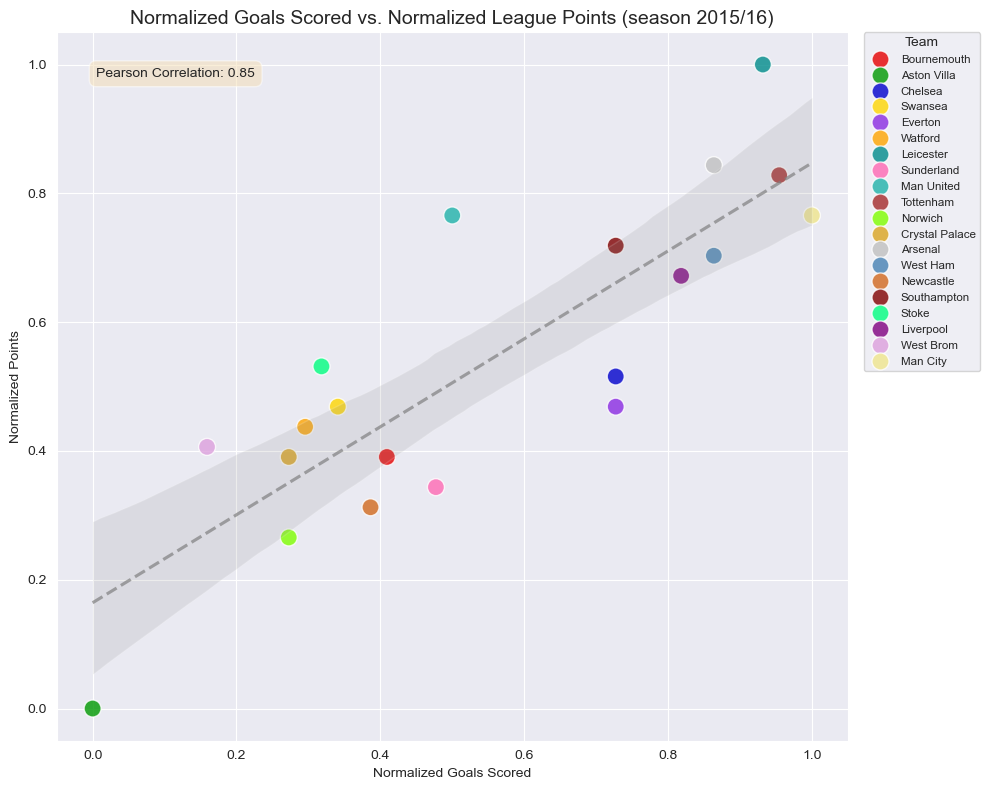

/var/folders/f3/vgmbz_1j6c375y52l9k_9l980000gn/T/ipykernel_69821/1029887958.py:44: UserWarning: The palette list has more values (46) than needed (20), which may not be intended.
  sns.scatterplot(


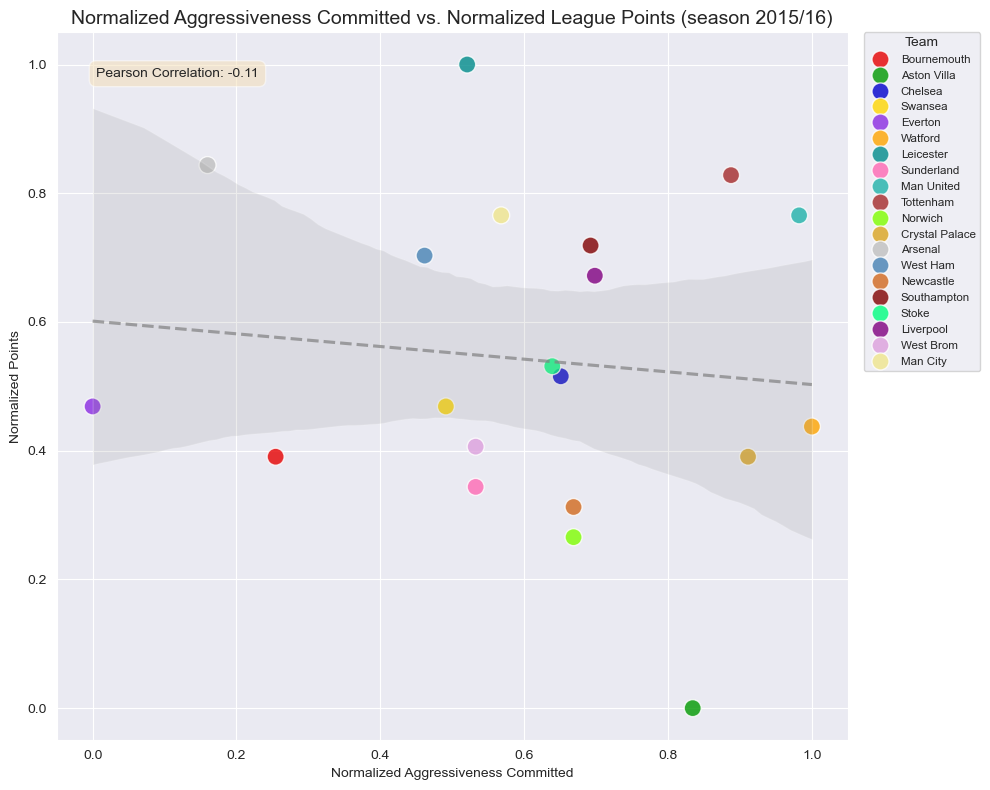

/var/folders/f3/vgmbz_1j6c375y52l9k_9l980000gn/T/ipykernel_69821/1029887958.py:44: UserWarning: The palette list has more values (46) than needed (20), which may not be intended.
  sns.scatterplot(


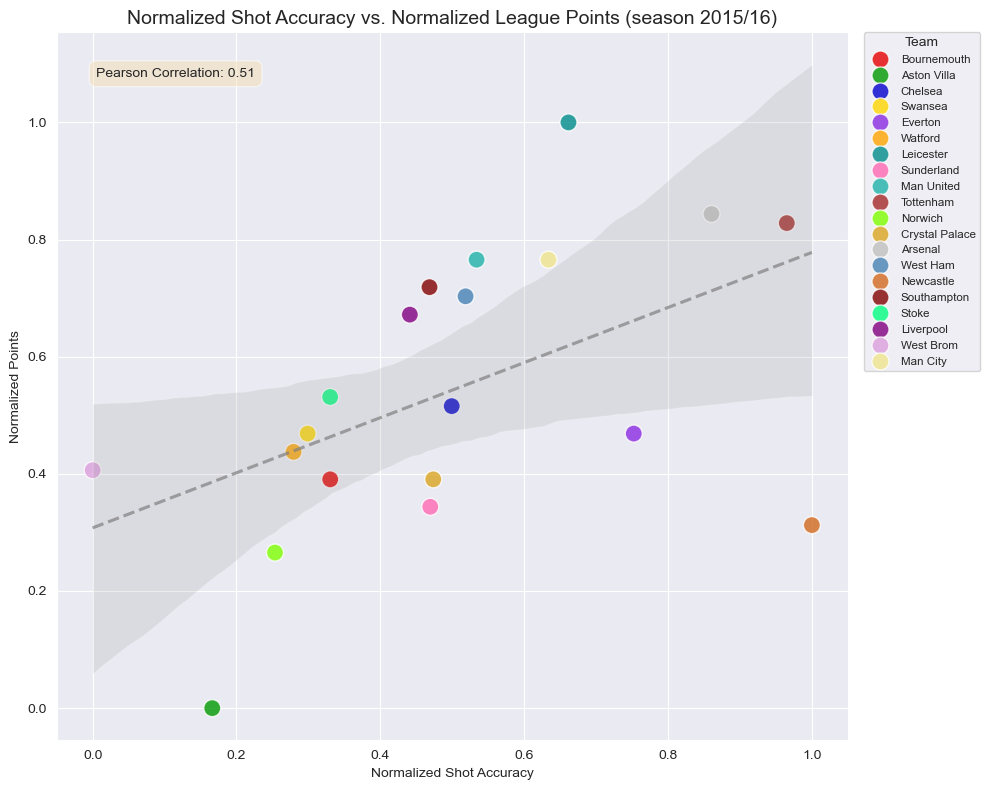

/var/folders/f3/vgmbz_1j6c375y52l9k_9l980000gn/T/ipykernel_69821/1029887958.py:44: UserWarning: The palette list has more values (46) than needed (20), which may not be intended.
  sns.scatterplot(


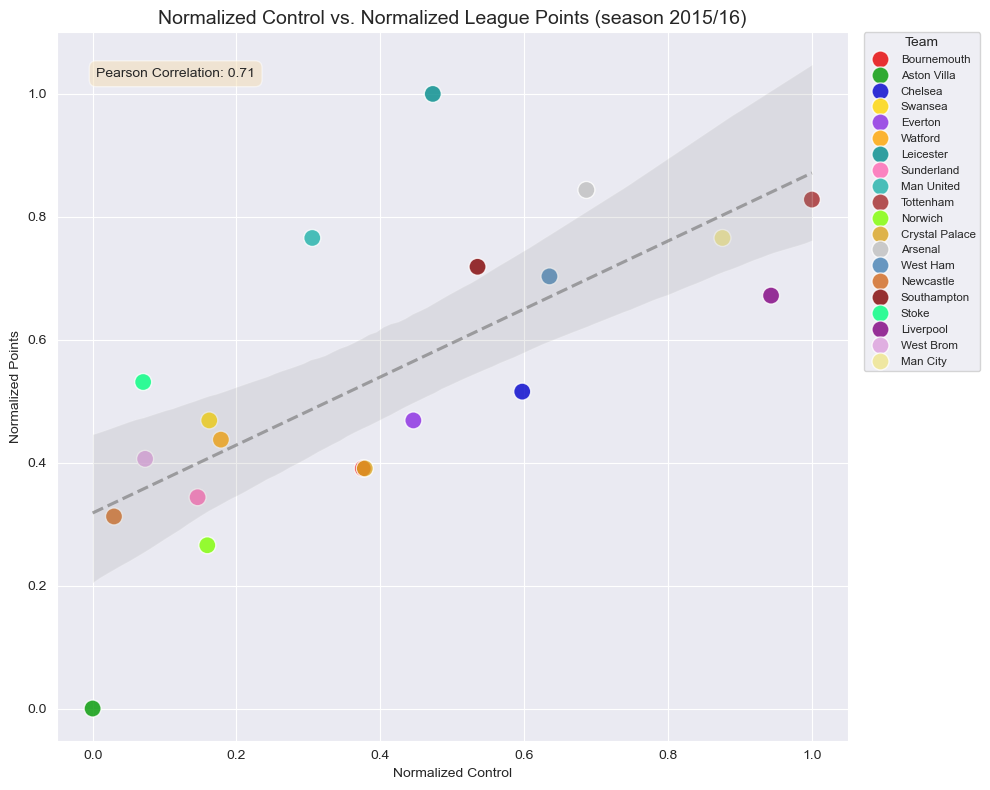


--- EPL Network Analysis Complete ---


In [68]:
# 1. Load the data
csv_file_path = '../data/epl_final.csv' # Adjust path as necessary
epl_df = load_data(csv_file_path)

if epl_df is None:
    print("Data loading failed. Exiting.")


# --- Scenario 1: Single Season Analysis (2016/17) with Normalized 'goals' ---
print("\n\n#####################################################################")
print("### Scenario 1: Single Season Analysis (2016/17) with Normalized 'goals' ###")
print("#####################################################################")
perform_epl_network_analysis(
    epl_df=epl_df,
    analysis_season='2015/16',
    metrics_to_analyze=['goals', 'aggressiveness', 'control', 'points'],
    thresholds_for_analysis=[0.2, 0.3, 0.3, 0.3],
    keep_above_threshold = False    
)



#####################################################################
### Scenario 2: Multi-Season Analysis (2013-2017) ###
#####################################################################

--- Starting EPL Network Analysis for seasons from 2013/14 to 2017/18 ---
Network created for seasons from 2013/14 to 2016/17 with 26 nodes and 610 edges.

--- Overall Network Properties (Initial Directed Graph) ---
Number of nodes: 26
Number of edges: 610
Network Density: 0.9385

--- Calculating Total Team Points across the provided data ---
Top 10 Teams by Total Points:
  Man City: 409 points
  Chelsea: 382 points
  Tottenham: 366 points
  Arsenal: 363 points
  Liverpool: 357 points
  Man United: 350 points
  Everton: 276 points
  Southampton: 261 points
  West Ham: 236 points
  Stoke: 232 points

--- Starting Unified Centrality and Community Analysis ---

### Analysis for Metric: 'goals' ###

--- Filtering graph for 'goals' with threshold 0.2 ---
Applying reciprocal filter for 'goals' with

/var/folders/f3/vgmbz_1j6c375y52l9k_9l980000gn/T/ipykernel_69821/1029887958.py:44: UserWarning: The palette list has more values (46) than needed (28), which may not be intended.
  sns.scatterplot(


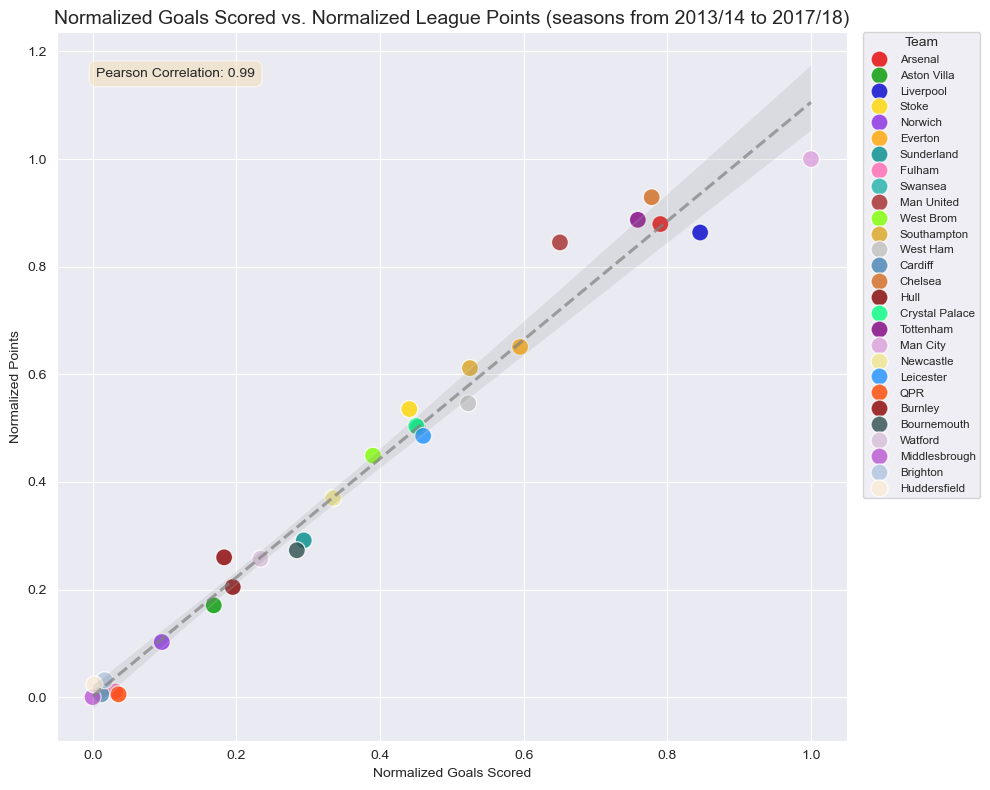

/var/folders/f3/vgmbz_1j6c375y52l9k_9l980000gn/T/ipykernel_69821/1029887958.py:44: UserWarning: The palette list has more values (46) than needed (28), which may not be intended.
  sns.scatterplot(


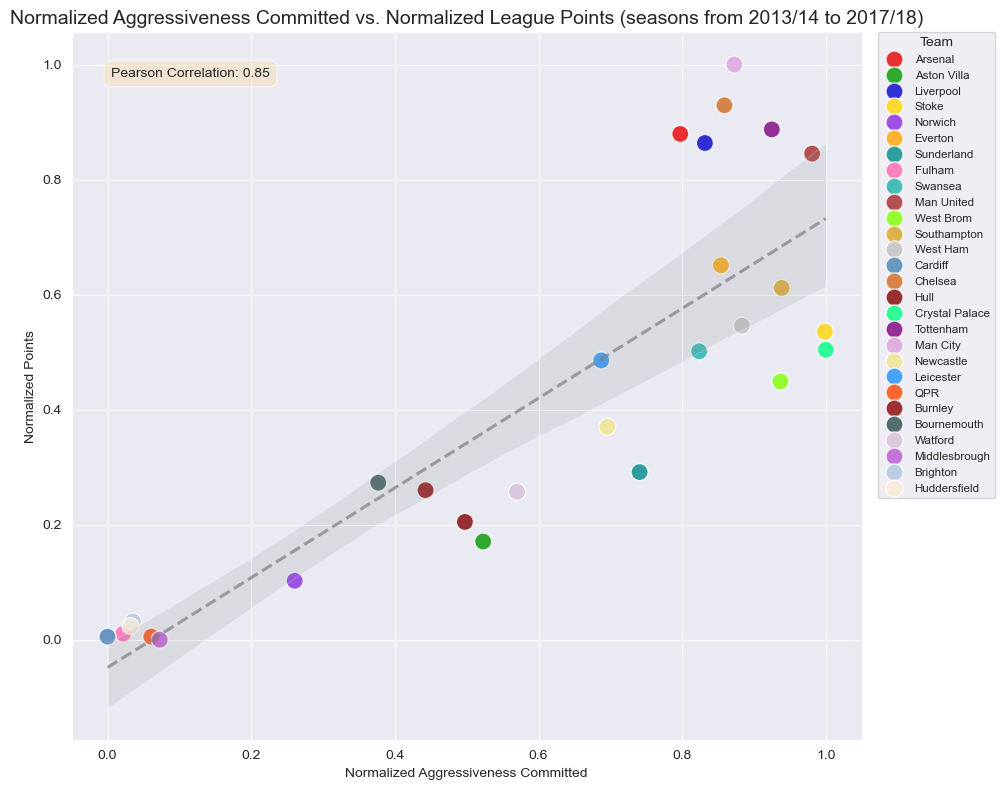

/var/folders/f3/vgmbz_1j6c375y52l9k_9l980000gn/T/ipykernel_69821/1029887958.py:44: UserWarning: The palette list has more values (46) than needed (28), which may not be intended.
  sns.scatterplot(


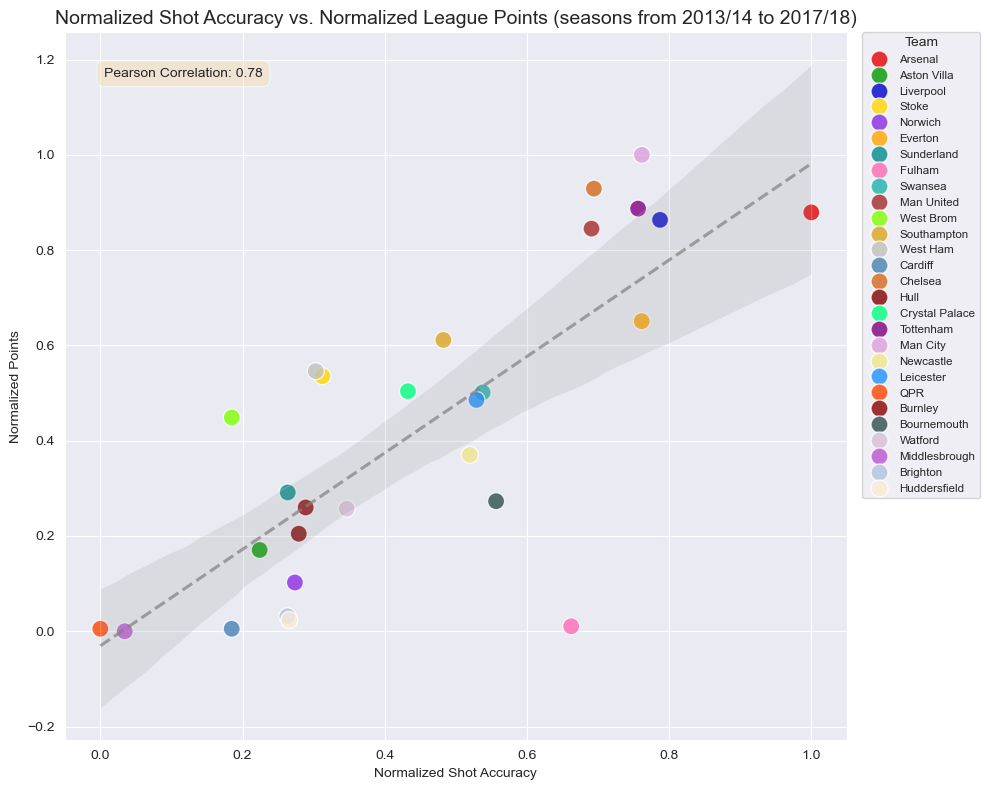

/var/folders/f3/vgmbz_1j6c375y52l9k_9l980000gn/T/ipykernel_69821/1029887958.py:44: UserWarning: The palette list has more values (46) than needed (28), which may not be intended.
  sns.scatterplot(


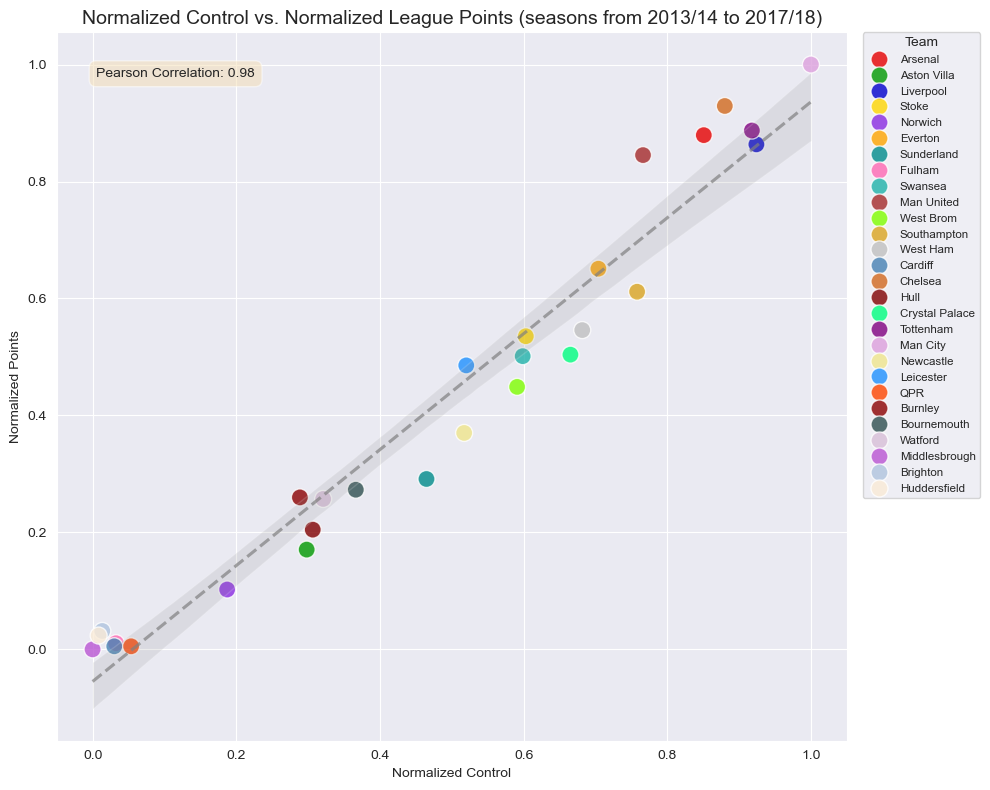


--- EPL Network Analysis Complete ---


In [69]:
print("\n\n#####################################################################")
print("### Scenario 2: Multi-Season Analysis (2013-2017) ###")
print("#####################################################################")
perform_epl_network_analysis(
    epl_df=epl_df,
    network_start_year=2013,
    network_end_year=2017,
    metrics_to_analyze=['goals', 'aggressiveness', 'control', 'points'],
    thresholds_for_analysis=[0.2, 0.3, 0.3, 0.3],
    keep_above_threshold = False  
    
)



#####################################################################
### Scenario 3: Single Season Analysis (2016/17) with Normalized 'goals' ###
#####################################################################

--- Starting EPL Network Analysis for season 2014/15 ---
Network created for season 2014/15 with 20 nodes and 380 edges.

--- Overall Network Properties (Initial Directed Graph) ---
Number of nodes: 20
Number of edges: 380
Network Density: 1.0000

--- Calculating Total Team Points across the provided data ---
Top 10 Teams by Total Points:
  Chelsea: 87 points
  Man City: 79 points
  Arsenal: 75 points
  Man United: 70 points
  Tottenham: 64 points
  Liverpool: 62 points
  Southampton: 60 points
  Swansea: 56 points
  Stoke: 54 points
  Crystal Palace: 48 points

--- Starting Unified Centrality and Community Analysis ---

### Analysis for Metric: 'goals' ###

--- Filtering graph for 'goals' with threshold 0.2 ---
Applying reciprocal filter for 'goals' with threshold 0.2 

/var/folders/f3/vgmbz_1j6c375y52l9k_9l980000gn/T/ipykernel_69821/1029887958.py:44: UserWarning: The palette list has more values (46) than needed (20), which may not be intended.
  sns.scatterplot(


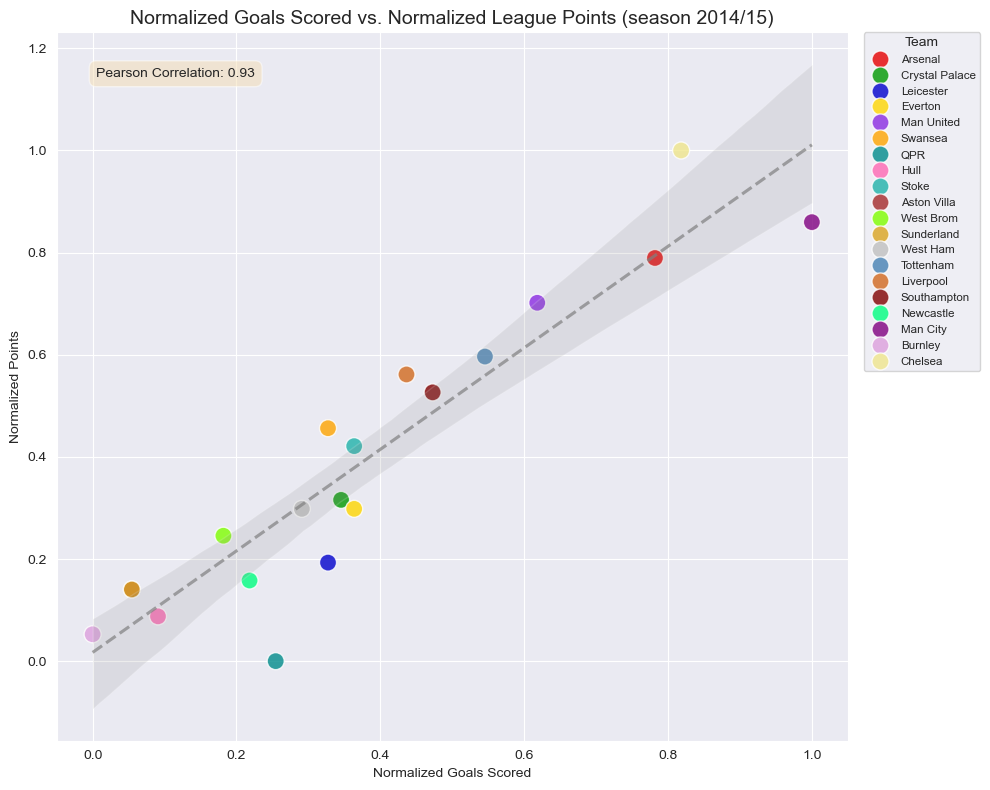

/var/folders/f3/vgmbz_1j6c375y52l9k_9l980000gn/T/ipykernel_69821/1029887958.py:44: UserWarning: The palette list has more values (46) than needed (20), which may not be intended.
  sns.scatterplot(


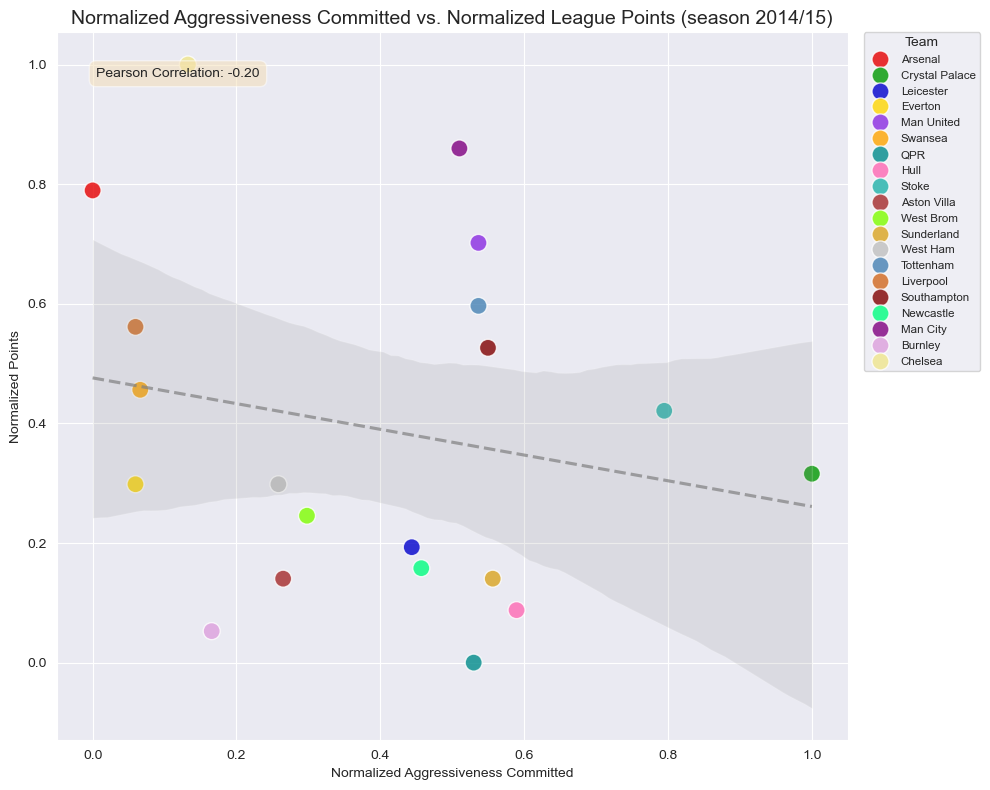

/var/folders/f3/vgmbz_1j6c375y52l9k_9l980000gn/T/ipykernel_69821/1029887958.py:44: UserWarning: The palette list has more values (46) than needed (20), which may not be intended.
  sns.scatterplot(


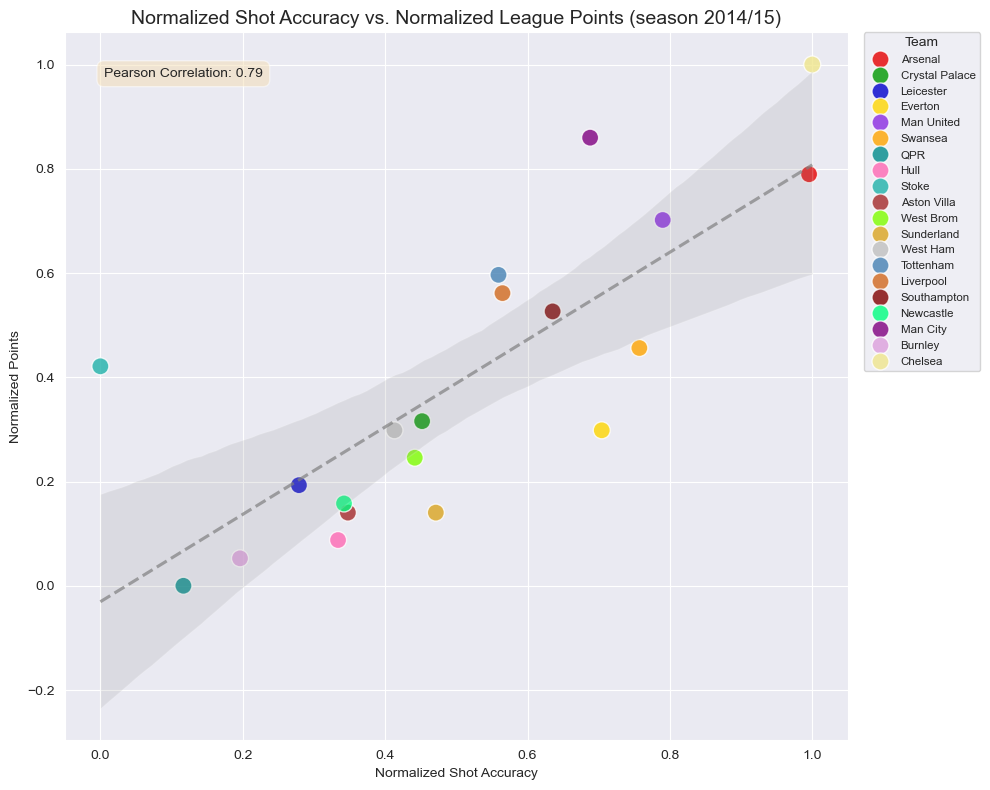

/var/folders/f3/vgmbz_1j6c375y52l9k_9l980000gn/T/ipykernel_69821/1029887958.py:44: UserWarning: The palette list has more values (46) than needed (20), which may not be intended.
  sns.scatterplot(


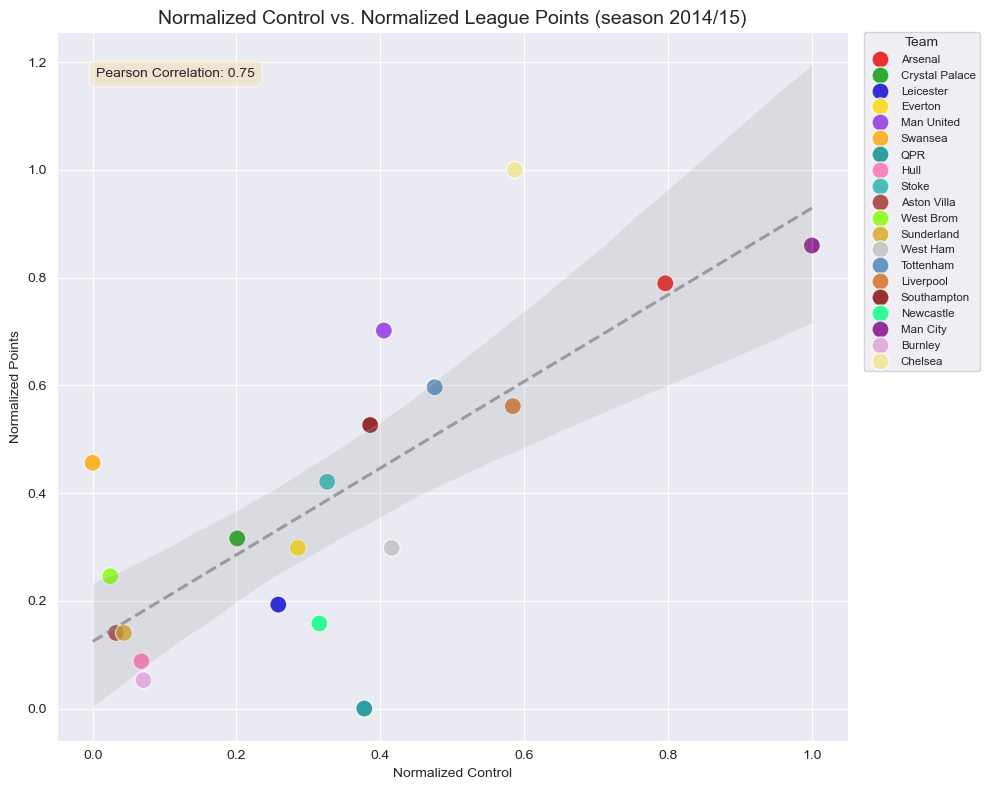


--- EPL Network Analysis Complete ---


In [70]:
# --- Scenario 1: Single Season Analysis (2016/17) with Normalized 'goals' ---
print("\n\n#####################################################################")
print("### Scenario 3: Single Season Analysis (2016/17) with Normalized 'goals' ###")
print("#####################################################################")
perform_epl_network_analysis(
    epl_df=epl_df,
    analysis_season='2014/15',
    metrics_to_analyze=['goals', 'aggressiveness', 'control', 'points'],
    thresholds_for_analysis=[0.2, 0.3, 0.3, 0.3],
    keep_above_threshold = False    
)